In [1]:
import rasterio
from rasterio.plot import show
from rasterio.windows import Window


import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import osmnx as ox

import seaborn as sns

from matplotlib import gridspec

from shapely.geometry import LineString
from shapely.geometry import Point, Polygon, MultiLineString


import math

from geopandas import GeoSeries

import geopy.distance
from geopy.distance import geodesic

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive

In [2]:
north = 55.6658  # North latitude
south = 55.6372  # South latitude
east = -3.1651   # East longitude
west = -3.2116   # West longitude

## River info Function

In [3]:
def river_list(*args): #, buffer = None):
    tags = {'waterway': 'river'}
    river_data = []
    #The following print the geometries ('geometries') and the geometry that is interested as a Polygon ('polygon'). 
    #If no rivers are present in the location, the code will stop and not print out results
    if len(args) == 1 and isinstance(args[0], str):
        name = args[0]
        print(f'Processing rivers in: {name}')
        geometries = ox.geometries_from_place(name, tags=tags)
        
        shape = ox.geometries_from_place(name, tags={'name': name})
        polygon = shape.unary_union
                
        if len(geometries) == 0:
            print(f'No rivers found in {name}')
            exit
        else:
            river_data.append((name, geometries))
    elif len(args) == 4:
        print('Processing rivers in lat long grid')
        geometries = ox.geometries_from_bbox(args[0], args[1], args[2], args[3], tags=tags)
        
        polygon= Polygon([(args[3],args[1]),(args[3],args[0]),(args[2],args[0]),(args[2],args[1])])
        
        if len(geometries) == 0:
            print('No rivers found in grid')
            exit
        else:
            river_data.append(('LatLongGrid', geometries))
            
    #This is for when the wrong number of arguments is passed
    else:
        print('Argument is not callable. Either-')
        print('        4 values: lat1, lat2, lon1, lon2')
        print('        1 value: The name of a given area')
        
    unique_names = river_data[0][1]['name'].dropna().unique()
    
    print(river_data[0][1]['name'].nunique(), 'Unique Rivers Extracted:')
    for value in unique_names:
        print('      ', value)
    return river_data[0][1][['geometry', 'name']], polygon

def cut_river_list(*args, buffer = None):
    #This uses the above function, and adds a buffer onto the river plot to avoid the large plot above
    #This is using a buffer that is in lat/long degree values, so that needs to be considered when picking a value
    river, polygon = river_list(*args)
    if buffer is None:
        return river, polygon
    else:
        river['new geometry'] = None
        buffered_polygon = polygon.buffer(buffer)
        
        for i in range(len(river)):
            riv = river.loc[river.index[i], 'geometry']
            k = riv.intersection(buffered_polygon)
            river.at[river.index[i], 'new geometry'] = k
        return river, polygon, buffered_polygon 

In [4]:
def river_elevation(geotiff_path, *args, buffer = None):
    #r, polygon = cut_river_list(*args, buffer = buffer)
    #r['elevations'] = None

    if buffer is None:
        r, polygon = cut_river_list(*args)
        r['elevations'] = None
        for i in range(len(r)):
            riv = r.loc[r.index[i], 'geometry']
            coords_list = list(riv.coords)
            
            elev = []
        
            with rasterio.open(geotiff_path) as src:
                vals = src.sample(coords_list)
                for val in vals:
                    elev.append(val[0])
                    
            r.at[r.index[i], 'elevations'] = elev
            
        return r
    else:
        r, polygon, buffered_polygon = cut_river_list(*args, buffer = buffer)
        r['elevations'] = None
    
    
    #This extracts the elevations and then adds it to the river function
        for i in range(len(r)):
            riv = r.loc[r.index[i], 'new geometry']
            coords_list = list(riv.coords)
            
            elev = []
        
            with rasterio.open(geotiff_path) as src:
                vals = src.sample(coords_list)
                for val in vals:
                    elev.append(val[0])
                    
            r.at[r.index[i], 'elevations'] = elev
            
        return r

In [5]:
r = river_elevation('Peebles-30m-DEM.tif', north, south, east, west, buffer = 0.005)

Processing rivers in lat long grid
2 Unique Rivers Extracted:
       River Tweed
       Eddleston Water


In [6]:
min_value = float('inf')
max_value = float('-inf')
for row in r['elevations']:
    for value in row:
        if value < min_value:
            min_value = value 
        if value > max_value:
            max_value = value
            
print(f'Min value = {min_value}')
print(f'Max value = {max_value}')

Min value = 156
Max value = 181


## Elevations

In [7]:
with rasterio.open('Peebles-30m-DEM.tif') as src:
    rofile = src.profile
    tid_dat = src.read(1)
    window = src.window(west-0.005, south-0.005, east+0.005, north+0.005)
    subset_data = src.read(1, window=window)

In [8]:
#specific_colour = 'Red'
chosen_value = min_value + 5

In [9]:
result = np.where(subset_data <= chosen_value, chosen_value, np.nan)

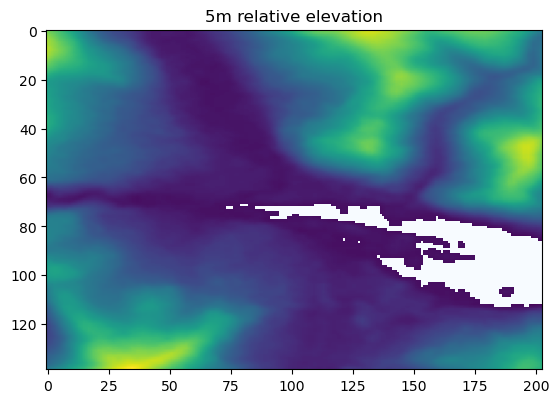

In [10]:
specific_colour = 'white'
chosen_value = min_value + 5

result = np.where(subset_data <= chosen_value, chosen_value, np.nan)

#fig, ax = plt.subplots()

subset_data = np.array(subset_data)
mask = subset_data == chosen_value
cmap = plt.get_cmap('viridis')
#cmap.set_bad(specific_colour)

     
plt.imshow(subset_data, cmap = cmap)
plt.title('5m relative elevation')
#plt.imshow(mask, cmap = cmap, alpha = 0.1)  
plt.imshow(result, cmap = 'Blues')

plt.savefig('elevation_downstream.png')

In [11]:
def plot_elevation(chosen_value):
    result = np.where(subset_data <= chosen_value, chosen_value, np.nan)
    
    # Convert subset_data to a masked array for plotting
    subset_data_masked = np.ma.masked_where(subset_data <= chosen_value, subset_data)
    
    # Create a colormap for the masked values
    cmap = plt.get_cmap('viridis')
    cmap.set_bad(specific_colour)
    
    # Create a figure for the plot
    fig, ax = plt.subplots()

    # Plot the elevation values
    im = ax.imshow(subset_data_masked, cmap=cmap)
    
    # Add a colorbar for reference using the mappable object
    cbar = plt.colorbar(im)
    
    # Set the title
    ax.set_title(f'Elevation Values <= {chosen_value}')

    # Display the plot
    plt.show()

# Create an interactive widget to select the chosen_value
chosen_value_widget = widgets.IntSlider(
    value=min_value,
    min=min_value,
    max=max_value+20,
    step=5,
    description='Chosen Value:'
)

# Use ipywidgets' interactive function to link the widget to the plot function
interactive_plot = interactive(plot_elevation, chosen_value=chosen_value_widget)


# Display the interactive plot
display(interactive_plot)


interactive(children=(IntSlider(value=156, description='Chosen Value:', max=201, min=156, step=5), Output()), …

/opt/conda/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


This shows that there is some level of elevation change across the river seen in Peebles. Highlighted again below.

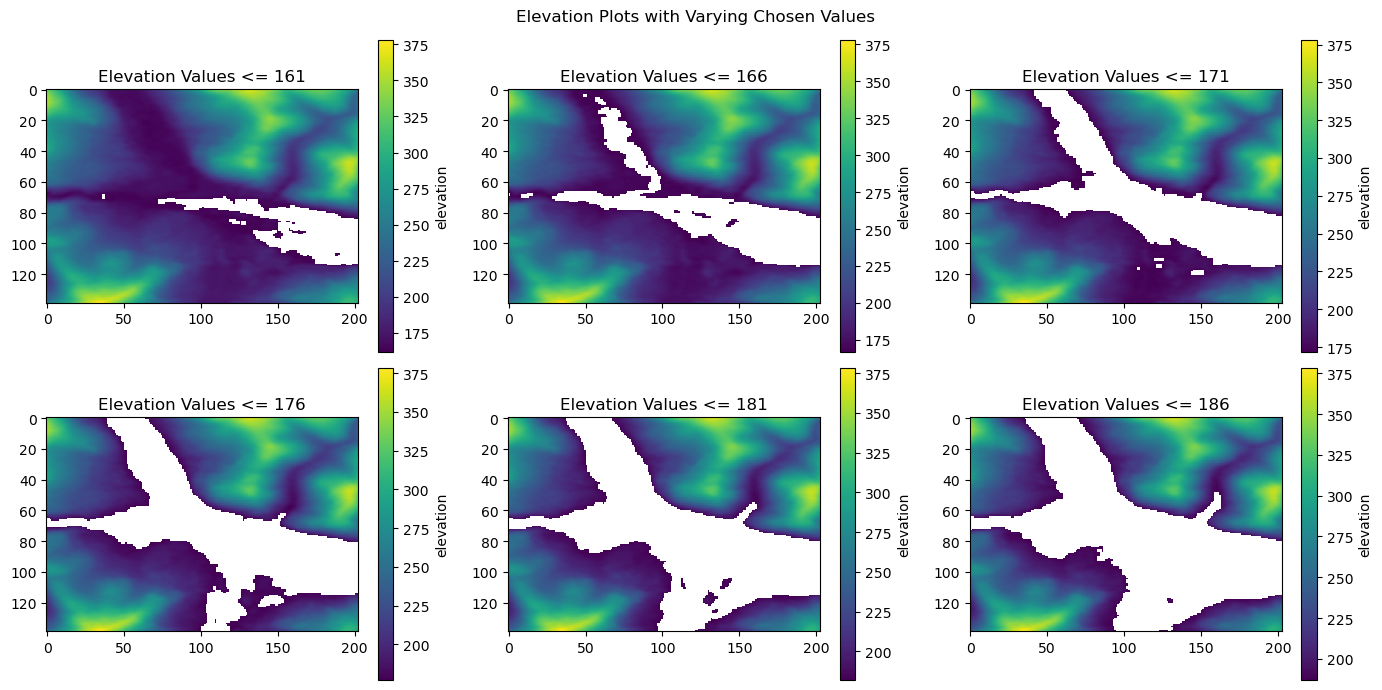

In [12]:
subset_data # Your 2D array of elevation values
min_value 
max_value # Adjust the maximum value as needed
specific_colour = 'white'

# Create a figure for the plots
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
fig.suptitle('Elevation Plots with Varying Chosen Values')

# Define the chosen values
chosen_values = [min_value +5, min_value +10,min_value +15,min_value +20,
                 min_value +25,min_value +30] # ,min_value, +35,min_value +40,min_value +45 ]

for i, ax in enumerate(axes.flat):
    chosen_value = chosen_values[i]
    result = np.where(subset_data <= chosen_value, chosen_value, np.nan)
    
    # Convert subset_data to a masked array for plotting
    subset_data_masked = np.ma.masked_where(subset_data <= chosen_value, subset_data)
    
    # Create a colormap for the masked values
    cmap = plt.get_cmap('viridis')
    cmap.set_bad(specific_colour)
    
    # Plot the elevation values
    im = ax.imshow(subset_data_masked, cmap=cmap)
    
    # Add a colorbar for reference
    plt.colorbar(im, ax=ax,label='elevation')
    
    # Set the title
    ax.set_title(f'Elevation Values <= {chosen_value}')

#cbar = fig.colorbar(mappable, ax=axes.ravel().tolist())
plt.tight_layout()
plt.savefig('elevations.png')
plt.show()

## Therefore:

Peebles is small and relatively flat, but the above plots show there is some level of elevation change between the lower and upper bounds of the two river channels. 

Therefore, one average elevation was not used within the flooding sub-package. 

The closest river node to each building was calculated, and from this the relative elevation was found between the two points. This avoided there being underestimations higher up the river channel and overestimations lower down the channel. 